This notebook is based on the file [Feature sets programming exercise](https://colab.research.google.com/notebooks/mlcc/feature_sets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=featuresets-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Sets

**Learning Objective:** Create a minimal set of features that performs just as well as a more complex feature set

So far, we've thrown all of our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal set of housing features that will perform equally as well as one that uses all the features in the data set.

## Setup

As before, let's load and prepare the California housing data.

In [2]:
using Plots
gr(fmt=:png)
using DataFrames
using TensorFlow
import CSV
import StatsBase
using Random
using Statistics

sess=Session()
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

2019-02-24 14:04:48.236897: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [3]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     :total_rooms,
     :total_bedrooms,
     :population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    
function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value] = (
    california_housing_dataframe[:median_house_value] ./ 1000.0)
  return output_targets
end

preprocess_targets (generic function with 1 method)

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(first(california_housing_dataframe,12000))
training_targets = preprocess_targets(first(california_housing_dataframe,12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(last(california_housing_dataframe,5000))
validation_targets = preprocess_targets(last(california_housing_dataframe,5000))

# Double-check that we've done the right thing.
println("Training examples summary:")
describe(training_examples)
println("Validation examples summary:")
describe(validation_examples)

println("Training targets summary:")
describe(training_targets)
println("Validation targets summary:")
describe(validation_targets)

Training examples summary:
Validation examples summary:
Training targets summary:
Validation targets summary:


,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,median_house_value,205.749,14.999,180.85,500.001,,,Float64


## Task 1: Develop a Good Feature Set

**What's the best performance you can get with just 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to other features.

Here, correlation is defined as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).  You don't have to understand the mathematical details for this exercise.

Correlation values have the following meanings:

  * `-1.0`: perfect negative correlation
  * `0.0`: no correlation
  * `1.0`: perfect positive correlation

The following function will create a correlation matrix from a DataFrame.

In [5]:
function cordf(df::DataFrame)
    out=DataFrame([cor(df[:, a], df[:, b]) for a=1:size(df, 2), b=1:size(df, 2)], names(df))
    return(out)
end

cordf (generic function with 1 method)

For our data, we obtain:

In [6]:
correlation_dataframe = copy(training_examples)
correlation_dataframe[:target] = training_targets[:median_house_value]
out=cordf(correlation_dataframe)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.924768,0.0207151,-0.0491701,-0.0790731,-0.121665,-0.0841454,-0.0803252,0.137552,-0.143086
2,-0.924768,1.0,-0.11589,0.0568381,0.0818775,0.111752,0.0680984,-0.016541,-0.0732938,-0.0491099
3,0.0207151,-0.11589,1.0,-0.351843,-0.313724,-0.288073,-0.295757,-0.106267,-0.0927955,0.108292
4,-0.0491701,0.0568381,-0.351843,1.0,0.926027,0.852183,0.914326,0.202663,0.114597,0.136771
5,-0.0790731,0.0818775,-0.313724,0.926027,1.0,0.874981,0.978074,-0.0110881,0.045526,0.0492994
6,-0.121665,0.111752,-0.288073,0.852183,0.874981,1.0,0.906578,-0.000999159,-0.13804,-0.0278365
7,-0.0841454,0.0680984,-0.295757,0.914326,0.978074,0.906578,1.0,0.00954448,-0.0390317,0.0657946
8,-0.0803252,-0.016541,-0.106267,0.202663,-0.0110881,-0.000999159,0.00954448,1.0,0.215625,0.693154
9,0.137552,-0.0732938,-0.0927955,0.114597,0.045526,-0.13804,-0.0390317,0.215625,1.0,0.192837


Ideally, we'd like to have features that are strongly correlated with the target.

We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

Use this information to try removing features.  You can also try developing additional synthetic features, such as ratios of two raw features.

For convenience, we've included the training code from the previous exercise.

In [7]:
function construct_columns(input_features)
  """Construct the Feature Columns.

  Args:
    input_features: Numerical input features to use.
  Returns:
    A set of converted feature columns
  """ 
  out=convert(Matrix, input_features[:,:])
  return convert(Matrix{Float64},out)
    
end
    

construct_columns (generic function with 1 method)

In [8]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end  
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)
    
    for i=1:num_epochs       
        select=shuffle(1:size(features,1))
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else          
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end    
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [9]:
function next_batch(features_batches, targets_batches, batch_size, iter)
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];   
    return ds, target
end

next_batch (generic function with 1 method)

In [10]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1)
    """Trains a linear regression model of one feature.
  
    Args:
      features: DataFrame of features
      targets: DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    #features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    #ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    # features, labels = ds.make_one_shot_iterator().get_next()
    return ds, target
end

my_input_fn (generic function with 3 methods)

In [11]:
function train_model(learning_rate,
                     steps, 
                     batch_size, 
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods
    
  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  # Configure the linear regression model with our feature columns and optimizer.
  m=Variable(zeros(size(training_examples,2),1))
  b=Variable(0.0)
  y=(feature_columns*m) .+ b
  loss=reduce_sum((target_columns - y).^2)
  run(sess, global_variables_initializer())
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)

  # Advanced gradient decent with gradient clipping
  my_optimizer=(train.GradientDescentOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
     
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    #println(construct_columns(features))
    #println(construct_columns(labels))
    run(sess, my_optimizer, Dict(feature_columns=>construct_columns(features), target_columns=>construct_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> construct_columns(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> construct_columns(validation_examples)));  
        
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end

  weight = run(sess,m)
  bias = run(sess,b)
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")

  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)
       
  return weight, bias, p1 #, calibration_data   
end

train_model (generic function with 1 method)

Spend 5 minutes searching for a good set of features and training parameters. Then check the solution to see what we chose. Don't forget that different features may require different learning parameters.

In [12]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = [:latitude,
    :median_income,
    :rooms_per_person,
    :total_bedrooms
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.003, #learning rate
    500, #steps
    5, #batch_size
    minimal_training_examples,
    training_targets,
    minimal_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 183.7392602245132
  period 2: 206.75150876495923
  period 3: 165.87993791913442
  period 4: 164.7679483284074
  period 5: 179.45652052917944
  period 6: 163.26477717777334
  period 7: 166.5608653030198
  period 8: 170.54872843543188
  period 9: 158.48629508215632
  period 10: 167.62633326469208
Model training finished.
Final RMSE (on training data): 167.62633326469208
Final Weight (on training data): [0.686872; 0.155786; 0.0428863; 0.302144]
Final Bias (on training data): 3.196519044607023


([0.686872; 0.155786; 0.0428863; 0.302144], 3.196519044607023, Plot{Plots.GRBackend() n=2})

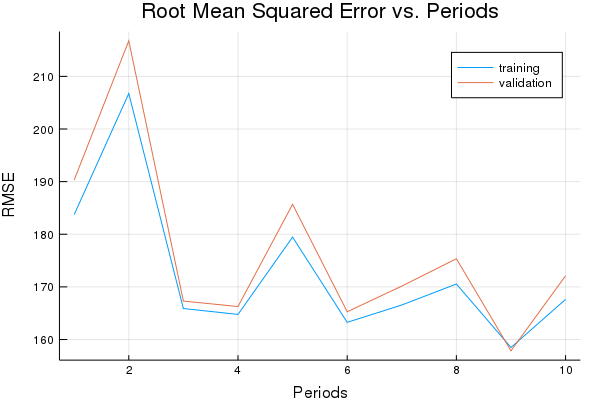

In [13]:
plot(p1)

### Solution

Click below for a solution.

In [14]:
minimal_features = [
  :median_income,
  :latitude,
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.01, #learning rate
    500, #steps
    5, #batch_size
    minimal_training_examples,
    training_targets,
    minimal_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 165.0985970722029
  period 2: 124.19657540259746
  period 3: 117.80756502081594
  period 4: 117.25684139473813
  period 5: 116.88559847743232
  period 6: 116.28598538447449
  period 7: 115.98012301500343
  period 8: 115.9458593580111
  period 9: 114.21584881804682
  period 10: 114.18447169380268
Model training finished.
Final RMSE (on training data): 114.18447169380268
Final Weight (on training data): [4.32013; 4.8583]
Final Bias (on training data): 5.247893056091381


([4.32013; 4.8583], 5.247893056091381, Plot{Plots.GRBackend() n=2})

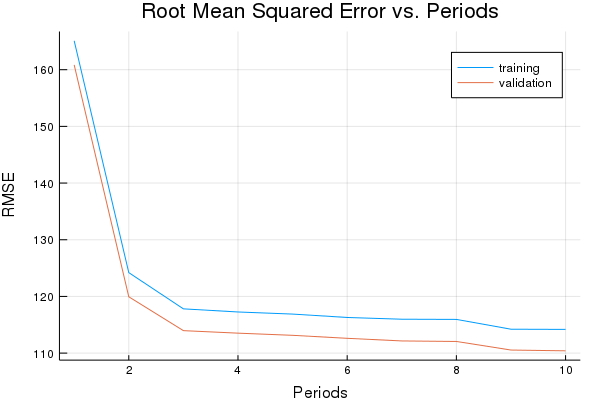

In [15]:
plot(p1)

## Task 2: Make Better Use of Latitude

Plotting `latitude` vs. `median_house_value` shows that there really isn't a linear relationship there.

Instead, there are a couple of peaks, which roughly correspond to Los Angeles and San Francisco.

In [16]:
#scatter(training_examples[:latitude], training_targets[:median_house_value])

**Try creating some synthetic features that do a better job with latitude.**

For example, you could have a feature that maps `latitude` to a value of `|latitude - 38|`, and call this `distance_from_san_francisco`.

Or you could break the space into 10 different buckets.  `latitude_32_to_33`, `latitude_33_to_34`, etc., each showing a value of `1.0` if `latitude` is within that bucket range and a value of `0.0` otherwise.

Use the correlation matrix to help guide development, and then add them to your model if you find something that looks good.

What's the best validation performance you can get?

In [17]:
lat1=32:41
lat2=33:42
lat_range=zip(lat1,lat2) # zip creates a set of tuples from vectors

function create_index(value, r1, r2)
    if value >=r1 && value <r2
        out=1.0
    else
        out=0.0
    end
    return out
end

function select_and_transform_features(source_df, lat_range)
    selected_examples=DataFrame()
    selected_examples[:median_income]=source_df[:median_income]
    
    # Symbol(string) allows to convert a string to a DataFrames name :string
    for range in lat_range
        selected_examples[Symbol(string("latitude_", range[1],"_", range[2]))]=create_index.(source_df[:latitude], range[1], range[2])
    end
        
    return selected_examples
end

select_and_transform_features (generic function with 1 method)

In [18]:
selected_training_examples = select_and_transform_features(training_examples, lat_range)
selected_validation_examples = select_and_transform_features(validation_examples, lat_range);

In [19]:
correlation_dataframe = copy(selected_training_examples)
correlation_dataframe[:target] = training_targets[:median_house_value]
out=cordf(correlation_dataframe)

,median_income,latitude_32_33,latitude_33_34,latitude_34_35,latitude_35_36,latitude_36_37,latitude_37_38,latitude_38_39,latitude_39_40,latitude_40_41,latitude_41_42,target
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.0461611,0.0798491,0.0268932,-0.0818347,-0.106086,0.136879,-0.0642332,-0.11522,-0.0866492,-0.054577,0.693154
2,-0.0461611,1.0,-0.144928,-0.150919,-0.0418442,-0.0660024,-0.138853,-0.087688,-0.0459155,-0.0328115,-0.0159071,-0.0610642
3,0.0798491,-0.144928,1.0,-0.318112,-0.0882006,-0.139122,-0.292678,-0.184832,-0.0967821,-0.0691612,-0.0335295,0.0689311
4,0.0268932,-0.150919,-0.318112,1.0,-0.0918468,-0.144873,-0.304777,-0.192472,-0.100783,-0.0720203,-0.0349156,0.123685
5,-0.0818347,-0.0418442,-0.0882006,-0.0918468,1.0,-0.040168,-0.0845035,-0.0533655,-0.0279434,-0.0199686,-0.0096808,-0.127083
6,-0.106086,-0.0660024,-0.139122,-0.144873,-0.040168,1.0,-0.13329,-0.0841753,-0.0440762,-0.0314971,-0.0152699,-0.175789
7,0.136879,-0.138853,-0.292678,-0.304777,-0.0845035,-0.13329,1.0,-0.177084,-0.0927253,-0.0662622,-0.032124,0.211228
8,-0.0642332,-0.087688,-0.184832,-0.192472,-0.0533655,-0.0841753,-0.177084,1.0,-0.0585577,-0.0418458,-0.0202869,-0.159032
9,-0.11522,-0.0459155,-0.0967821,-0.100783,-0.0279434,-0.0440762,-0.0927253,-0.0585577,1.0,-0.0219114,-0.0106227,-0.150613


In [20]:
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.01, #learning rate
    1500, #steps
    5, #batch_size
    selected_training_examples,
    training_targets,
    selected_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 202.2772070655988
  period 2: 167.2989175502785
  period 3: 134.76365553300957
  period 4: 107.52030372796295
  period 5: 92.51799718077424
  period 6: 86.03199391863457
  period 7: 84.45828539342742
  period 8: 84.06088173431573
  period 9: 84.07858353750237
  period 10: 83.7300253769773
Model training finished.
Final RMSE (on training data): 83.7300253769773
Final Weight (on training data): [41.3982; 0.0286937; 3.31032; 4.70875; -0.380607; -1.0631; 4.79874; -0.908675; -0.524214; -0.386934; -0.142933]
Final Bias (on training data): 42.14021193860397


([41.3982; 0.0286937; … ; -0.386934; -0.142933], 42.14021193860397, Plot{Plots.GRBackend() n=2})

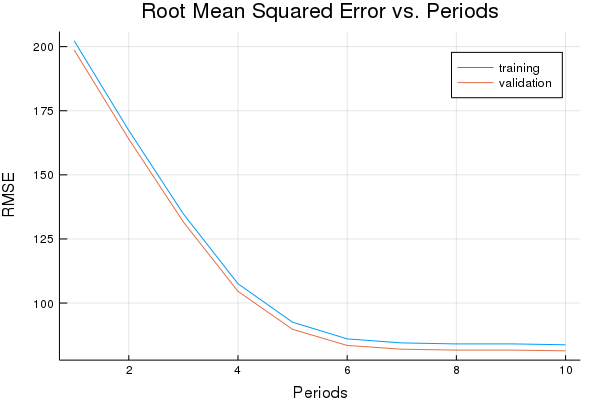

In [21]:
plot(p1)

In [22]:
#EOF